# But de notebook

On cherche ici à modéliser la probabilité qu'une personne rembourse ou non un emprunt contracté auprès de l'institution HomeCredit à partir d'une large base de données de ses clients.\
Conformément aux instructions, on ne cherchera pas ici à réaliser le _feature engineering_ de zéro, mais on se servira au contraire du kernel Lightgbm_with_simple_features. Ce kernel permet en principe de réaliser toute la chaîne de modélisation et de prédiction, mais nous ne réutiliserons ici que la partie _feature engineering_, qu'on va chercher à compléter ici de manière à appliquer d'autres modèles que celui proposé dans le kernel (LightGBM).

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import lightgbm_with_simple_features as lgbmsf
import json
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import os

from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

with open('config.json', 'r') as f:
    config = json.load(f)
    
NUM_ROWS = config["NUM_ROWS"]
PATH = config["PATH"]

## I. Création de la table finale

In [3]:
# liste des fichiers
os.listdir(PATH)

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'home_credit.png',
 'HomeCredit_columns_description.csv',
 'imputer_selection.py',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'Projet+Mise+en+prod+-+home-credit-default-risk.zip',
 'sample_submission.csv']

Il y a 9 fichiers, et on sait par la description donnée sur kaggle qu'ils sont liés entre eux via le schéma suivant

![home_credit](./data/home_credit.png)

## I.1 Jointures des tables

On réalise la jointure de toutes les tables en utilisant les clés correspondantes à l'exception de la table application_test.csv qui correspond aux données utilisées pour la compétition kaggle.\
Les jointures sont réalisées grâce au kernel kaggle dont on a modifié légèrement le code pour utiliser cette fonctionnalité indépendamment.

In [4]:
# Jointures
data = lgbmsf.join_df(num_rows=NUM_ROWS)

Train samples: 15000
Bureau df shape: (2984, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (14432, 245)
Process previous_applications - done in 1s
Pos-cash balance df shape: (14088, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (12780, 26)
Process installments payments - done in 0s
Credit card balance df shape: (13667, 131)
Process credit card balance - done in 1s


## I.2 Nettoyage et imputations

Retirons les colonnes remplies à moins de 70%

In [7]:
nna = data.notna().sum()/data.shape[0]
nfilled_cols = nna[nna<0.7].index
filled_data = data.drop(columns=nfilled_cols)

### Imputations

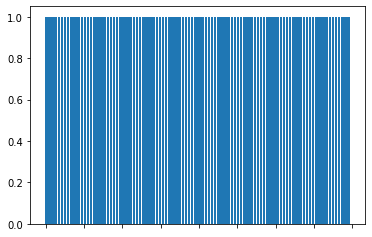

In [8]:
filled_data.fillna(filled_data.mean(), inplace=True)
nna = filled_data.notna().sum()/filled_data.shape[0]
fig, ax = plt.subplots()
ax.bar(x=np.arange(len(filled_data.columns)), height=nna)
ax.set_xticklabels('')
plt.show()

## I.3 Prédictions

### I.3.1 Préparation des jeux de données

In [11]:
feats = filled_data.drop(columns=['SK_ID_CURR', 'TARGET']).columns
X = filled_data.drop(columns=['SK_ID_CURR', 'TARGET']).to_numpy()
y = filled_data.TARGET.to_numpy()

# Séparation en jeux d'entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### I.3.2 Baselines - Classification naïves avec DummyClassifier

Pour pouvoir interpréter les résultats obtenus, on va comparer les scores de prédiction avec les scores obtenus par des approches naïves. Elles sont implémentées dans la classe  DummyClassifier  du module  dummy  de scikit-learn.

1. Prédire la même classe pour tous les échantillons : la classe la plus fréquente dans le jeu d'entraînement. Cette approche naïve nous permet d’évaluer si le modèle que nous proposons a appris « plus » que simplement quelle est la classe la plus fréquente. C’est particulièrement intéressant si une des classes est beaucoup plus fréquente que les autres. Pensez que pour un problème de classification binaire sur des données contenant 90% d’échantillons positifs, un classifieur qui retourne systématiquement « positif » aura une accuracy de 90%.

2. Prédire une classe aléatoirement, dans les mêmes proportions que dans le jeu d'entraînement. Cette approche naïve nous permet d’évaluer si les performances que nous observons ne seraient pas simplement dûes aux proportions relatives des classes.

3. Retourner aléatoirement des scores selon une distribution uniforme, puis leur appliquer un seuil pour obtenir une prédiction binaire. Cette méthode est recommandée quand on cherche à interpréter une courbe ROC ou une AUROC, elles-mêmes construites à partir de classifieurs qui retournent des scores.

**1. La classe majoritaire est prédite systématiquement**

In [12]:
dummyclf = DummyClassifier(strategy='most_frequent',)
dummyclf.fit(X_train, y_train)
y_pred = dummyclf.predict(X_test)
print("AUROC Score : {:.2f}".format(roc_auc_score(y_test, y_pred)))

AUROC Score : 0.50


**2. Les étiquettes sont prédites aléatoirement parmi {0, 1}**

In [13]:
dummyclf = DummyClassifier(strategy='uniform')
dummyclf.fit(X_train, y_train)
y_pred = dummyclf.predict(X_test)
print("AUROC Score : {:.2f}".format(roc_auc_score(y_test, y_pred)))

AUROC Score : 0.50


### I.3.2 Prédictions avec LightGBM

In [14]:
# Séparation en jeux d'entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)


# Création du pipeline
model = LGBMClassifier(objective='binary', metric='AUC', is_unbalance=True)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Evaluation du modèle
print("\nPerformance sur le jeu de test' : {:.3f}".format(roc_auc_score(y_test, y_pred)))


Performance sur le jeu d'entraînement' : 0.623


On obtient déjà des performances en légère amélioration par rapport à une classification naïve. Pour aller plus loin, on va chercher à:
- "améliorer" le jeu de données
- optimiser les hyperparamètres

In [ ]:
# Séparation en jeu d'entraînement/validation pour la recherche sur grille
X_val_train, X_val_val, y_val_train, y_val_val = \
train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

# Nested cross-validation pour la validation du (des) hyperparamètre(s) par GridSearch
#inner_cv = StratifiedKFold(n_splits=5).split(X_train, y_train)

# Hyperparamètre(s) à optimiser
param_grid = {"n_estimators" : [100, 1000, 10000],
              "max_depth" : [-1, 5, 10], 
              "colsample_bytree" : [0.5, 0.8, 1],
              "num_leaves" : [10, 30, 50],
             }    

#for params in ParameterGrid(param_grid):
model = LGBMClassifier(early_stopping_round=200,
                               objective='binary',
                               metric='AUC',
                               is_unbalance=True,
                               silent=False,
                               verbosity=-1,
                              )

# Régression avec sélection d'(des)hyperparamètre(s) par validation croisée
regr = GridSearchCV(
estimator=model,            # modèle
param_grid=param_grid,     # hyperparamètres à tester
cv=5,    # nombre de folds de validation croisée
scoring='roc_auc',   # score à optimiser
return_train_score=True,
)

# Optimisation de l'estimateur sur le jeu d'entraînement
regr.fit(X=X_train, y=y_train, eval_set=(X_val_val, y_val_val), verbose=-1)

# Afficher le(s) hyperparamètre(s) optimaux
print("\nMeilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)

In [ ]:
#bestmodel = LGBMClassifier(early_stopping_round=200,
#                               objective='binary',
#                               metric='AUC',
#                               is_unbalance=True,
#                               silent=False,
#                               verbosity=-1,
#                           **regr.best_params_)
#
#bestmodel.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=-1)
#y_pred = bestmodel.predict(X_test)
#
# Performance sur le jeu d'entraînement
print("\nPerformance sur le jeu d'entraînement' : {:.3f}".format(regr.best_score_))

# Performance en généralisation du meilleur modèle sur le jeu de test
y_pred = regr.predict(X_test)
print("Performance en généralisation sur le jeu de test : {:.3f}".format(roc_auc_score(y_test, y_pred)))